In [2]:
import os
from pathlib import Path

import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
from sklearn.manifold import MDS
from sklearn import manifold
from sklearn.decomposition import PCA

import ot
import shutil
from tqdm import tqdm
## IMPORT USER DEFINED LIBRARIES ##################################################################
import utils


c:\Users\cocar\Documents\Repositories\GW_BCM\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils

In [14]:
import secrets

def simplex_grid(N=20):
    """Generate points on a 2D simplex grid (triangle) with N divisions per edge."""    
    N = 20
    pts = []
    for l in range(N + 1):
        for j in range(N + 1 - l):
            k = N - l - j
            pts.append((l / N, j / N, k / N))
    pts=np.array(pts)
    return pts

def random_rbf_deformation(pts,
                           num_ctrl=20,
                           sigma=0.3,
                           max_disp=0.3,
                           seed=None):
    """
    pts: (N, 2) array in some domain, e.g. [0,1]^2
    num_ctrl: number of random control points
    sigma: RBF width (in units of the domain)
    max_disp: max magnitude of control displacements (same units as coords)
    """
    if seed is None:
        seed = secrets.randbits(256)
    rng = np.random.default_rng(seed)

    # 1) Random control points within bounding box of pts
    mins = pts.min(axis=0)
    maxs = pts.max(axis=0)
    ctrl_pts = rng.uniform(mins, maxs, size=(num_ctrl, 2))

    # 2) Random displacements assigned to control points
    ctrl_disp = rng.uniform(-max_disp, max_disp, size=(num_ctrl, 2))

    # 3) Compute RBF weights for each data point
    #    shape: (N, num_ctrl)
    diff = pts[:, None, :] - ctrl_pts[None, :, :]      # (N, K, 2)
    sqdist = np.sum(diff**2, axis=-1)                  # (N, K)
    weights = np.exp(-sqdist / (2.0 * sigma**2))       # (N, K)

    # Normalize weights so they don't blow up
    weights_sum = np.sum(weights, axis=1, keepdims=True) + 1e-12
    weights = weights / weights_sum

    # 4) Interpolated displacement field at pts
    disp = weights @ ctrl_disp                          # (N, 2)

    # 5) Deformed points
    pts_deformed = pts + disp
    return pts_deformed, disp, ctrl_pts, ctrl_disp, seed


def plot_point_cloud(pts, title='Point Cloud'):
    """Plot 2D point cloud. pts is (N, 2) array."""
    plt.figure(figsize=(4,4))
    plt.scatter(pts[:,0], pts[:,1], s=10, c='k')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()
    plt.show() 

def compute_distance_matrix(pts):
    """Compute pairwise Euclidean distance matrix for pts."""
    diff = pts[:, None, :] - pts[None, :, :]  # (N, N, 2)
    dist_matrix = np.sqrt(np.sum(diff**2, axis=-1))  # (N, N)
    return dist_matrix  

def get_Fs(matrix_temp_list, measure_temp_list, matrix_input, measure_input):
    '''
    Computes the auxiliary matrices F_s for the Gromov-Wasserstein barycenter problem.

    Input:
      matrix_temp_list: List of S template matrices (Ns x Ns) representing different dissimilarity matrices.
      measure_temp_list: List of S probability vectors (length Ns), representing probability measures of the S templates.
      matrix_input: (M x M) matrix representing the dissimilarity matrix to analyze (array).
      measure_input: Probability vector of length M (array)

    Output:
      F_list: List of auxiliary matrices F_s for the Gromov-Wasserstein barycenter problem. (list of arrays)
    '''

    S = len(matrix_temp_list)  # Number of template matrices

    pi_list = []  # List to store Gromov-Wasserstein transport plans
    F_list = []  # List to store transformed matrices

    # Compute Q matrix (inverse of the outer product of measure_input)
    Q = (measure_input.reshape(-1, 1) @ measure_input.reshape(1, -1))
    Q = 1. / Q  # Element-wise inverse

    # Compute Gromov-Wasserstein transport maps and one iteration of the forward GW-barycenter problem
    for s in range(S):
        # Compute optimal transport plan (pi_s) using Gromov-Wasserstein transport
        pi_s = ot.gromov.gromov_wasserstein(matrix_temp_list[s], matrix_input,
                                            measure_temp_list[s], measure_input)
        pi_list.append(pi_s)

        # Compute F_s transformation using Q and pi_s
        F_s = Q * (pi_s.T @ matrix_temp_list[s] @ pi_s)  # Element-wise multiplication
        F_list.append(F_s)
    
    return F_list

def get_norm_F(lambdas, matrix_temp_list, measure_temp_list, matrix_input, measure_input):
    '''
    Computes the norm of the weighted sum of auxiliary matrices F_s for the Gromov-Wasserstein barycenter problem.

    Input:
        lambdas: Weights for each template matrix (array of length S).
        matrix_temp_list: List of S template matrices (Ns x Ns) representing different dissimilarity matrices.
        measure_temp_list: List of S probability vectors (length Ns), representing probability measures of the S templates.
        matrix_input: (M x M) matrix representing the dissimilarity matrix to analyze (array).
        measure_input: Probability vector of length M (array)
    Output:
        norm_F: Frobenius norm of the difference between matrix_input and the weighted sum of F_s matrices. (float)
    '''

    F_list = get_Fs(matrix_temp_list, measure_temp_list, matrix_input, measure_input)
    F_weighted_sum = sum(lambdas[s] * F_list[s] for s in range(len(F_list)))
    norm_F = np.linalg.norm(matrix_input - F_weighted_sum, 'fro')
    return norm_F

# Generate

Number of points in simplex grid with N=20: 231


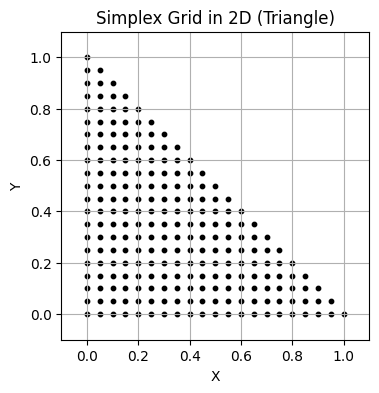

In [65]:
# ----------------------------------------------
# Generate simplex grid --> triangle (3 templates)
# ---------------------------------------------- 
N = 20
pts = simplex_grid(N) 
print('Number of points in simplex grid with N={}: {}'.format(N, pts.shape[0]))

plot_point_cloud(pts[:, :2], title='Simplex Grid in 2D (Triangle)')

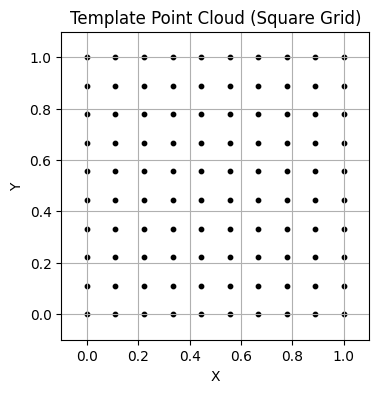

In [66]:
# ----------------------------------------------
# Generate a template cloud point in 2D that is a uniform grid in a square
# ----------------------------------------------
n_pts_per_side = 10
x = np.linspace(0, 1, n_pts_per_side)
y = np.linspace(0, 1, n_pts_per_side)
X, Y = np.meshgrid(x, y)
template_pts = np.vstack([X.ravel(), Y.ravel()]).T  # shape (n_pts_per_side**2, 2)          

plot_point_cloud(template_pts, title='Template Point Cloud (Square Grid)')
 

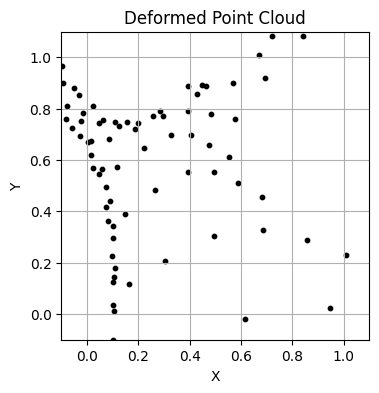

In [67]:
# -----------------------------------------------
# Example: Generate a random deformation of the template cloud
# -----------------------------------------------
deformed_pts, disp, ctrl_pts, ctrl_disp, seed = random_rbf_deformation(
    template_pts,
    num_ctrl=15,
    sigma=0.2,
    max_disp=1,
)

plot_point_cloud(deformed_pts, title='Deformed Point Cloud')


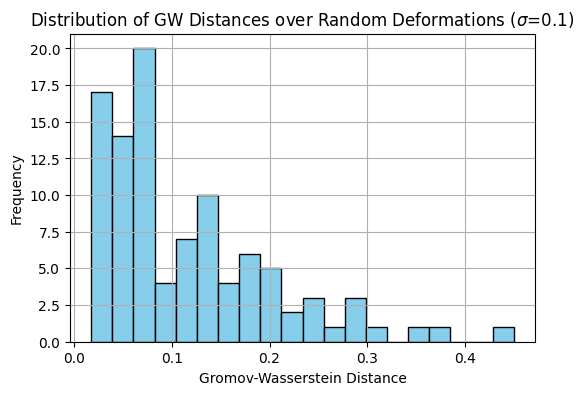

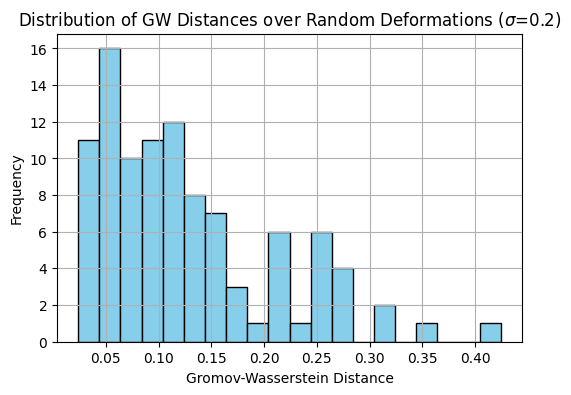

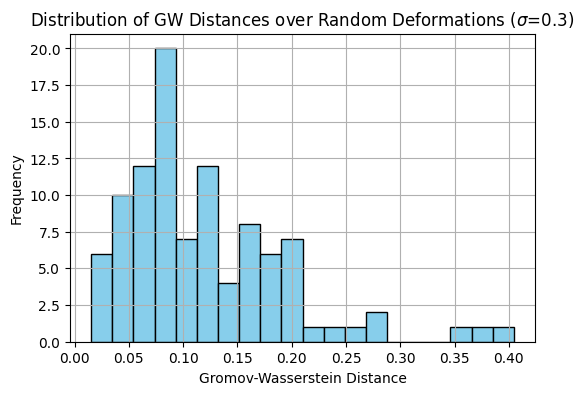

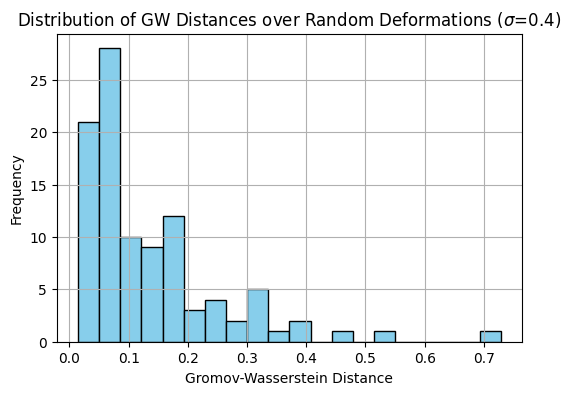

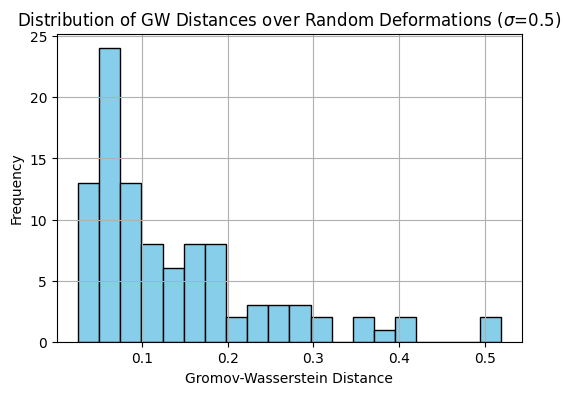

In [ ]:
# ----------------------------------------------
# Explore distribution of GW distances over multiple runs to test how the deformation varies the GW distance
# ----------------------------------------------

sigma = 0.2
num_control = 5
max_disp = 2.0

for sigma in [0.1, 0.2, 0.3, 0.4, 0.5]:
    gw_dist_list = np.zeros(100)
    template_dist_matrix = compute_distance_matrix(template_pts)
    for i in range(len(gw_dist_list)):
        deformed_pts, disp, ctrl_pts, ctrl_disp, seed = random_rbf_deformation(
        template_pts,
        num_ctrl=10,
        sigma=0.2,
        max_disp=1,
        )
        gw_dist_list[i] = ot.gromov.gromov_wasserstein2(
            compute_distance_matrix(deformed_pts),
            template_dist_matrix,
            ot.unif(deformed_pts.shape[0]),
            ot.unif(template_pts.shape[0]),
            'square_loss'
        )

    plt.figure(figsize=(6,4))
    plt.hist(gw_dist_list, bins=20, color='skyblue', edgecolor='k')
    plt.xlabel('Gromov-Wasserstein Distance to uniform grid template')
    plt.ylabel('Frequency')
    plt.title(rf'Distribution of GW Distances over Random Deformations ($\sigma$={sigma})')
    plt.grid()
    plt.show()


In [69]:
# ----------------------------------------------
# Search for three deformation parameters that yield GW distances to the uniform template larger than a threshold
# ----------------------------------------------        

template_dist_matrix = compute_distance_matrix(template_pts)
threshold = 0.5
parameter_records = []
gw_dist_list = []
for i in range(100):
    #print(f'Iteration {i+1}/100')
    sigma = np.random.uniform(0.1, 0.5)
    num_control = np.random.randint(5, 20)
    max_disp = np.random.uniform(0.5, 1.5)

    deformed_pts, disp, ctrl_pts, ctrl_disp, seed = random_rbf_deformation(
        template_pts,
        num_ctrl=num_control,
        sigma=sigma,
        max_disp=max_disp,
    )
    gw_dist = ot.gromov.gromov_wasserstein2(
        compute_distance_matrix(deformed_pts),
        template_dist_matrix,
        ot.unif(deformed_pts.shape[0]),
        ot.unif(template_pts.shape[0]),
        'square_loss'
    )

    if gw_dist > threshold:
        parameter_records.append((sigma, num_control, max_disp, gw_dist, seed))
        gw_dist_list.append(gw_dist)
        print(f'Found deformation with GW distance {gw_dist:.4f} > {threshold}')
        print(f'Parameters: sigma={sigma:.4f}, num_control={num_control}, max_disp={max_disp:.4f}')
        # plot_point_cloud(deformed_pts, title=f'Deformed Point Cloud (GW Dist={gw_dist:.4f})')    

# ----------------------------------------------
# Check that parameters_recorded can be used to regenerate  the corresponding deformed point clouds and distance matrices
# ----------------------------------------------

gw_dist_list_recovered = []
for idx, (sigma, num_control, max_disp, gw_dist, seed) in enumerate(parameter_records):
    deformed_pts, disp, ctrl_pts, ctrl_disp, seed = random_rbf_deformation(
            template_pts,
            num_ctrl=num_control,
            sigma=sigma,
            max_disp=max_disp,
            seed=seed,
        )
    dist_matrix = compute_distance_matrix(deformed_pts)
    gw_dist_recovered = ot.gromov.gromov_wasserstein2(
        dist_matrix,
        template_dist_matrix,
        ot.unif(deformed_pts.shape[0]),
        ot.unif(template_pts.shape[0]),
        'square_loss'
    )
    gw_dist_list_recovered.append(gw_dist_recovered)

print('Original GW distances:', gw_dist_list)   
print('Recovered GW distances:', gw_dist_list_recovered)

Found deformation with GW distance 0.8187 > 0.5
Parameters: sigma=0.1436, num_control=13, max_disp=1.4979
Found deformation with GW distance 0.6923 > 0.5
Parameters: sigma=0.1723, num_control=18, max_disp=1.3539
Found deformation with GW distance 0.6228 > 0.5
Parameters: sigma=0.2241, num_control=5, max_disp=1.3975
Original GW distances: [np.float64(0.8187035834092842), np.float64(0.6922858077049273), np.float64(0.6228419603624227)]
Recovered GW distances: [np.float64(0.8187035834092842), np.float64(0.6922858077049273), np.float64(0.6228419603624227)]


In [ ]:
# -----------------------------------------------
# Save generated point clouds and distance matrices to disk
# -----------------------------------------------




if False: # Change to false if you don't want to overwrite existing data
    # Eliminates previous data directory and creates a new one
    output_dir = Path('./20-Exp-generated_data')  
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)      
    os.makedirs(output_dir)

    # Save template point cloud and distance matrix
    template_dist_matrix = compute_distance_matrix(template_pts)
    np.savez(output_dir / 'template_point_cloud.npz',
                            points=template_pts,
                            distance_matrix=template_dist_matrix)
    # Save deformed point clouds and distance matrices for each parameter set found
    for idx, (sigma, num_control, max_disp, gw_dist, seed) in enumerate(parameter_records):
        deformed_pts, disp, ctrl_pts, ctrl_disp, seed = random_rbf_deformation(
            template_pts,
            num_ctrl=num_control,
            sigma=sigma,
            max_disp=max_disp,
            seed=seed,
        )
        dist_matrix = compute_distance_matrix(deformed_pts)
        np.savez(
            output_dir / f'deformed_point_cloud_{idx+1}.npz',
            points=deformed_pts,
            distance_matrix=dist_matrix,
            sigma=sigma,
            num_control=num_control,
            max_disp=max_disp,
            seed=seed,
            gw_distance=gw_dist
        )
    print(f'Saved {len(parameter_records)} deformed point clouds to {output_dir}')

Saved 3 deformed point clouds to 20-Exp-generated_data


In [4]:
# ----------------------------------------------
# Load and compute pairwise GW distance matrix between all generated point clouds
# ----------------------------------------------

output_dir = Path('./20-Exp-generated_data')
num_clouds = len(os.listdir(output_dir))
gw_distance_matrix = np.zeros((num_clouds, num_clouds))     

# Load template distance matrix
template_data = np.load(output_dir / 'template_point_cloud.npz')     
template_dist_matrix = template_data['distance_matrix']
gw_distance_matrix[0, 0] = 0.0  # GW distance of template to itself is zero



# Compute GW distances between template and deformed clouds
for idx in range(1, num_clouds):
    deformed_data = np.load(output_dir / f'deformed_point_cloud_{idx}.npz')
    deformed_dist_matrix = deformed_data['distance_matrix']
    gw_dist = ot.gromov.gromov_wasserstein2(
        deformed_dist_matrix,
        template_dist_matrix,
        ot.unif(deformed_dist_matrix.shape[0]),
        ot.unif(template_dist_matrix.shape[0]),
        'square_loss'
    )
    gw_distance_matrix[0, idx] = gw_dist
    gw_distance_matrix[idx, 0] = gw_dist    
# Compute GW distances between deformed clouds
for i in range(1, num_clouds):
    for j in range(i + 1, num_clouds):
        data_i = np.load(output_dir / f'deformed_point_cloud_{i}.npz')
        data_j = np.load(output_dir / f'deformed_point_cloud_{j}.npz')
        dist_matrix_i = data_i['distance_matrix']
        dist_matrix_j = data_j['distance_matrix']
        gw_dist = ot.gromov.gromov_wasserstein2(
            dist_matrix_i,
            dist_matrix_j,
            ot.unif(dist_matrix_i.shape[0]),
            ot.unif(dist_matrix_j.shape[0]),
            'square_loss'
        )
        gw_distance_matrix[i, j] = gw_dist
        gw_distance_matrix[j, i] = gw_dist   

# Print GW distance matrix
print('Pairwise GW Distance Matrix:')
print(gw_distance_matrix)      
           


FileNotFoundError: [Errno 2] No such file or directory: '20-Exp-generated_data\\deformed_point_cloud_4.npz'

In [5]:
# ----------------------------------------------
# Load and generate Gromov-Wasserstein barycenters from the first three deformed point clouds and weights in the simplex
# ----------------------------------------------
# Change to True to recompute barycenters and distances to target
output_dir = Path('./20-Exp-generated_data')
# Load template distance matrix to use as target
template_data = np.load(output_dir / 'template_point_cloud.npz')     
template_dist_matrix = template_data['distance_matrix']
target_dist_matrix = template_dist_matrix

# Load first three deformed point clouds   
assert len(os.listdir(output_dir)) >= 4, "Need at least 3 deformed point clouds saved."     
deformed_dist_matrices = []
for idx in range(1, 4):
    deformed_data = np.load(output_dir / f'deformed_point_cloud_{idx}.npz')
    deformed_pts = deformed_data['points']
    deformed_dist_matrix = deformed_data['distance_matrix']
    deformed_dist_matrices.append(deformed_dist_matrix)


if False:
    import signal 

    class TimeoutException(Exception):
        pass
    def timeout_handler(signum, frame):
        raise TimeoutException
    signal.signal(signal.SIGALRM, timeout_handler)

    max_time = 2 # seconds


    # Iterate over weights in the simplex and compute GW barycenters and their GW distances to the target
    simplex_grid_points = simplex_grid(N=10)
    simplex_gromov_wasserstein_distances_to_target = []
    for weight_idx, weight in enumerate(tqdm(simplex_grid_points)):
        weights = weight / np.sum(weight)  # Normalize to sum to 1
        try:
            signal.alarm(max_time)  # Set the timeout alarm
            barycenter_dist_matrix = ot.gromov.gromov_barycenters(
                deformed_pts.shape[0], 
                Cs = deformed_dist_matrices, 
                lambdas=weight, 
                loss_fun='square_loss'
            )
            gw_dist_to_target = ot.gromov.gromov_wasserstein2(
            barycenter_dist_matrix,
            target_dist_matrix,
            ot.unif(barycenter_dist_matrix.shape[0]),
            ot.unif(target_dist_matrix.shape[0]),
            'square_loss'
            )
            signal.alarm(0)  # Disable the alarm if completed in time
            simplex_gromov_wasserstein_distances_to_target.append(gw_dist_to_target)
        except TimeoutException:
            simplex_gromov_wasserstein_distances_to_target.append(np.nan)

    np.savez(output_dir / 'Bary_distances_to_target.npz',
                                simplex_grid_points=simplex_grid_points,
                                deformed_dist_matrices=deformed_dist_matrices,
                                target_dist_matrix=target_dist_matrix,
                                simplex_gromov_wasserstein_distances_to_target=simplex_gromov_wasserstein_distances_to_target
                                )    



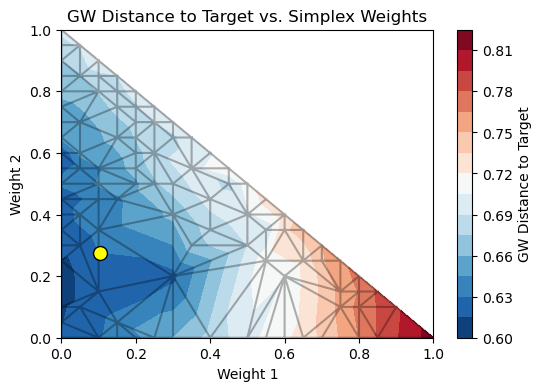

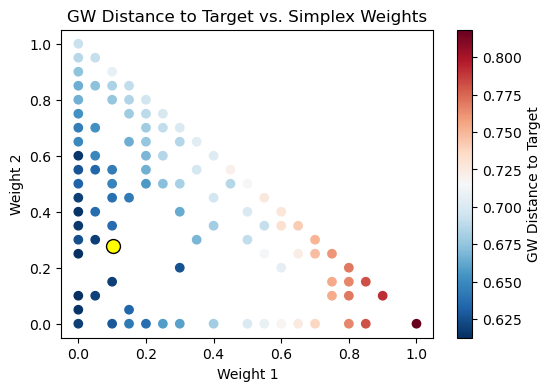

In [9]:
import matplotlib.tri as tri


bary_dist_data = np.load(output_dir / 'Bary_distances_to_target.npz')
simplex_grid_points = bary_dist_data['simplex_grid_points']
simplex_gromov_wasserstein_distances_to_target = bary_dist_data['simplex_gromov_wasserstein_distances_to_target']

#print('GW Distances to Target:', simplex_gromov_wasserstein_distances_to_target)

# Compute analysis of target 
deformed_measures = []
for i in range(3):
    deformed_measures.append(ot.unif(deformed_dist_matrices[i].shape[0]))
_, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_matrix, ot.unif(target_dist_matrix.shape[0]))


# Clean up NaN values for plotting
z = simplex_gromov_wasserstein_distances_to_target
mask = np.isnan(z)
z_masked = z[~mask]
x_grid_points = simplex_grid_points[~mask,0]
y_grid_points = simplex_grid_points[~mask,1]

# Plot GW distances to target vs. simplex weights
plt.figure(figsize=(6,4))
plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=14, cmap="RdBu_r")
plt.colorbar(label='GW Distance to Target')
plt.xlabel('Weight 1')
plt.ylabel('Weight 2')
plt.title('GW Distance to Target vs. Simplex Weights')
# Add triangulation grid
triang = tri.Triangulation(x_grid_points, y_grid_points)
plt.triplot(triang, color='k', alpha=0.3)
plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
plt.show()


# Scatter plot of GW distances to target vs. simplex weights
plt.figure(figsize=(6,4))
plt.scatter(x_grid_points, y_grid_points, c=z_masked, cmap='RdBu_r')
plt.colorbar(label='GW Distance to Target')
plt.xlabel('Weight 1')
plt.ylabel('Weight 2')
plt.title('GW Distance to Target vs. Simplex Weights')
plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
plt.show()


# True barycenter and permutations heat map 

Analysis method for true barycenters is independent of matrix permutations. 


100%|██████████| 231/231 [00:09<00:00, 24.85it/s]


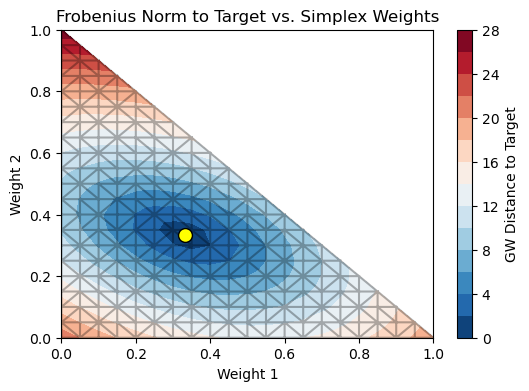

100%|██████████| 231/231 [00:09<00:00, 25.65it/s]


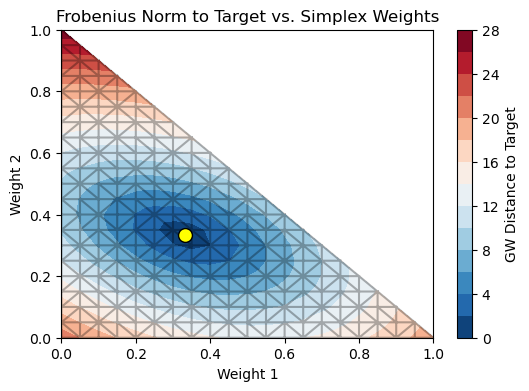

100%|██████████| 231/231 [00:09<00:00, 25.53it/s]


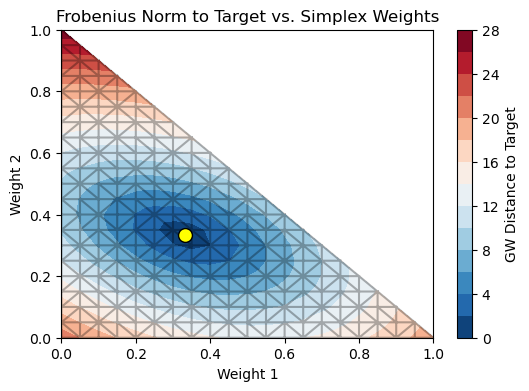

100%|██████████| 231/231 [00:08<00:00, 26.54it/s]


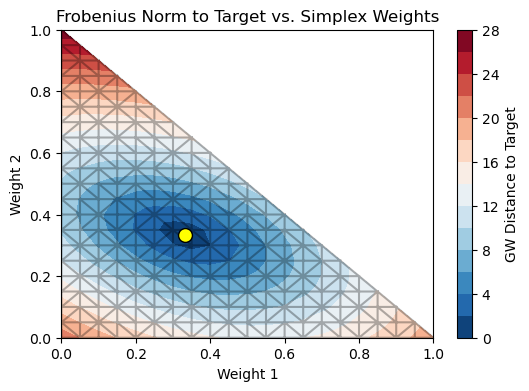

100%|██████████| 231/231 [00:08<00:00, 26.24it/s]


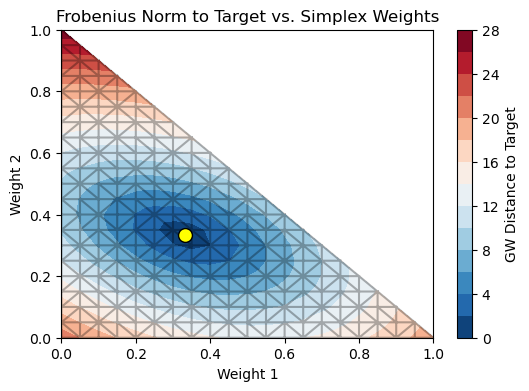

100%|██████████| 231/231 [00:08<00:00, 26.03it/s]


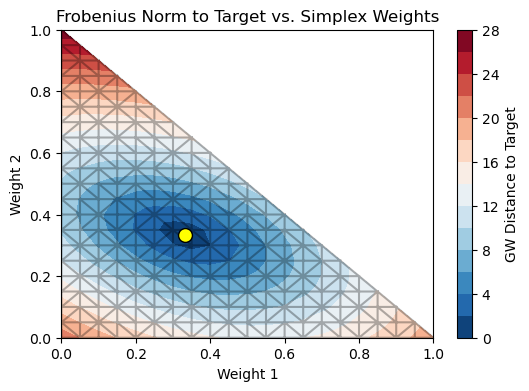

100%|██████████| 231/231 [00:08<00:00, 26.20it/s]


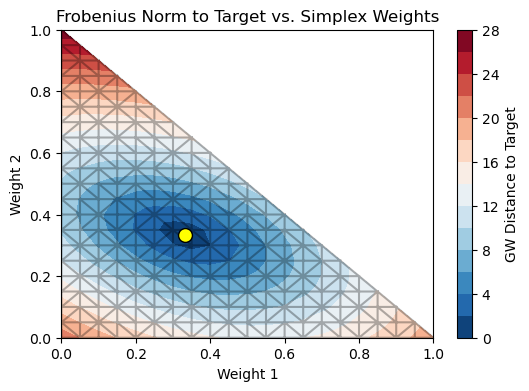

100%|██████████| 231/231 [00:09<00:00, 24.95it/s]


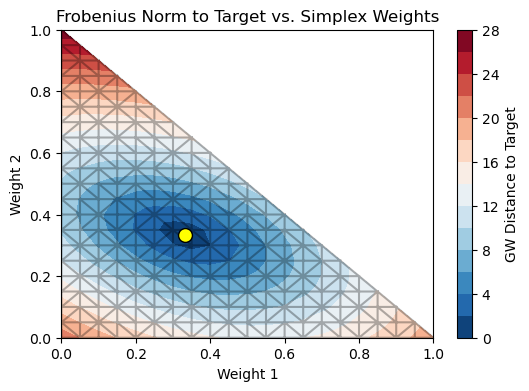

100%|██████████| 231/231 [00:09<00:00, 25.27it/s]


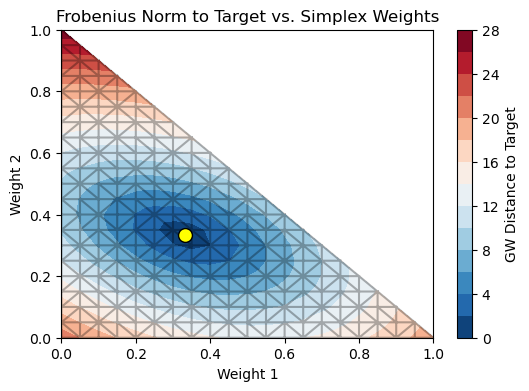

100%|██████████| 231/231 [00:09<00:00, 25.00it/s]


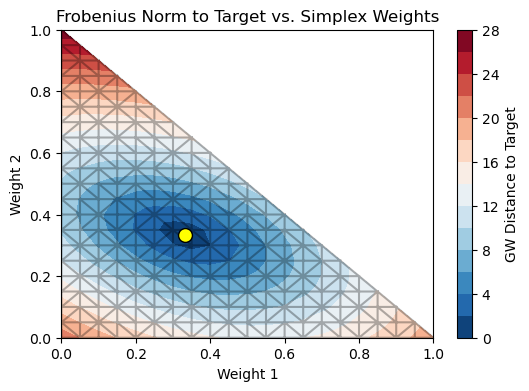

In [30]:
# Iterate over weights in the simplex and compute GW barycenters and their GW distances to the target
#target_dist_matrix_permuted = template_dist_matrix.copy()

lambda_test  = np.array([1, 1, 1])/3
target_dist_matrix_permuted = ot.gromov.gromov_barycenters(
    template_dist_matrix.shape[0], 
    Cs = deformed_dist_matrices, 
    lambdas=lambda_test, 
    loss_fun='square_loss'
)
simplex_grid_points = simplex_grid(N=10)

for _ in range(10):
    simplex_frobenius_distances_to_permuted_target = []
    for weight_idx, weight in enumerate(tqdm(simplex_grid_points)):
        weights = weight / np.sum(weight)  # Normalize to sum to 1
        norm_F = get_norm_F(weights, deformed_dist_matrices, deformed_measures, target_dist_matrix_permuted, ot.unif(target_dist_matrix_permuted.shape[0]))
        simplex_frobenius_distances_to_permuted_target.append(norm_F)
    
    # Clean up NaN values for plotting
    z = np.array(simplex_frobenius_distances_to_permuted_target)
    mask = np.isnan(z)
    z_masked = z[~mask]
    x_grid_points = simplex_grid_points[~mask,0]
    y_grid_points = simplex_grid_points[~mask,1]

    # Plot GW distances to target vs. simplex weights
    plt.figure(figsize=(6,4))
    plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=14, cmap="RdBu_r")
    plt.colorbar(label='GW Distance to Target')
    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.title('Frobenius Norm to Target vs. Simplex Weights')
    # Add triangulation grid
    triang = tri.Triangulation(x_grid_points, y_grid_points)
    plt.triplot(triang, color='k', alpha=0.3)
    _, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_matrix_permuted, ot.unif(target_dist_matrix_permuted.shape[0]))
    plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
    plt.show()

    perm = np.random.permutation(target_dist_matrix_permuted.shape[0])
    target_dist_matrix_permuted = target_dist_matrix_permuted[perm][:, perm]




100%|██████████| 231/231 [00:14<00:00, 15.68it/s]


<Figure size 600x400 with 0 Axes>

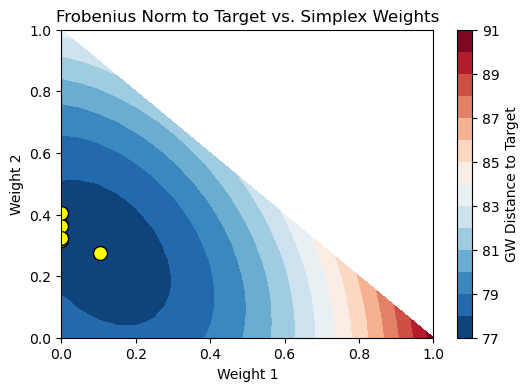

In [36]:
# Iterate over weights in the simplex and compute GW barycenters and their GW distances to the target
target_dist_matrix_permuted = template_dist_matrix.copy()
simplex_grid_points = simplex_grid(N=10)

plt.figure(figsize=(6,4))
for _ in range(1):
    simplex_frobenius_distances_to_permuted_target = []
    for weight_idx, weight in enumerate(tqdm(simplex_grid_points)):
        weights = weight / np.sum(weight)  # Normalize to sum to 1
        norm_F = get_norm_F(weights, deformed_dist_matrices, deformed_measures, target_dist_matrix_permuted, ot.unif(target_dist_matrix_permuted.shape[0]))
        simplex_frobenius_distances_to_permuted_target.append(norm_F)
    
    # Clean up NaN values for plotting
    z = np.array(simplex_frobenius_distances_to_permuted_target)
    mask = np.isnan(z)
    z_masked = z[~mask]
    x_grid_points = simplex_grid_points[~mask,0]
    y_grid_points = simplex_grid_points[~mask,1]

    # Plot GW distances to target vs. simplex weights
    plt.figure(figsize=(6,4))
    plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=14, cmap="RdBu_r")
    plt.colorbar(label='GW Distance to Target')
    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.title('Frobenius Norm to Target vs. Simplex Weights')
    # Add triangulation grid
    #triang = tri.Triangulation(x_grid_points, y_grid_points)
    #plt.triplot(triang, color='k', alpha=0.3)

recovered_lambdas = []
for _ in range(8):
    _, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_matrix_permuted, ot.unif(target_dist_matrix_permuted.shape[0]))
    plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
    recovered_lambdas.append(lambdas)
    #plt.show()

    perm = np.random.permutation(target_dist_matrix_permuted.shape[0])
    target_dist_matrix_permuted = target_dist_matrix_permuted[perm][:, perm]

plt.show()

In [ ]:
# TODO: Statistics on recovered lambdas
